# Worm-eating Warbler Occurrence Records Summary
This notebook is a tool for exploring data sets requested from GBIF (and eventually other sources), and mostly for developing criteria for filtering records (filter sets).  When the entire notebook is run, it retrieves records according to the filter sets specified and saves the results (records and some summary tables) in an sqlite database.  Some information is pulled from the parameters.sqlite database that is saved in this repository.

### General Setup

In [1]:
%matplotlib inline
import sqlite3
import pprint
import json
import pandas as pd
import numpy as np
#import geopandas as gpd
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.max_rows', 150)
from IPython.display import Image
from pygbif import occurrences
import matplotlib.pyplot as plt
import os
from datetime import datetime
t1 = datetime.now()
import repo_functions as functions

### Set Variables
Fill out stuff in this cell.

In [2]:
species_id = 'bwewax0'
summary_name = 'TWSwormie'
gbif_req_id = 'GBIFr17'
gbif_filter_id = 'GBIFf6'
workDir = '/Users/nmtarr/Documents/Occurrence_Records/'
codeDir = '/Users/nmtarr/Code/occurrence-records-wrangler/'
inDir = workDir + 'Inputs/'
outDir = workDir + 'Outputs/'
default_coordUncertainty = 2000
SRID_dict = {'WGS84': 4326, 'AlbersNAD83': 102008} # Used in file names for output.
spdb = outDir + species_id + gbif_req_id + gbif_filter_id + '.sqlite'

print("Notebook run " + str(t1))

Notebook run 2019-08-28 14:16:27.342790


In [3]:
connjup = sqlite3.connect(codeDir + 'parameters.sqlite')
cursorjup = connjup.cursor()

# Get some variables
years = connjup.execute("""SELECT years_range 
                           FROM gbif_requests WHERE request_id = '{0}'""".format(gbif_req_id)).fetchone()[0]
gap_id = connjup.execute("""SELECT gap_id
                            FROM species_concepts WHERE species_id = '{0}'""".format(species_id)).fetchone()[0]
common_name = connjup.execute("""SELECT common_name
                                 FROM species_concepts WHERE species_id = '{0}'""".format(species_id)).fetchone()[0]

# Species Concept
Display information on the species from the parameters.sqlite database.

In [4]:
vals = cursorjup.execute("SELECT * FROM species_concepts WHERE species_id = '{0}';".format(species_id)).fetchall()[0]
cols = [x[1] for x in cursorjup.execute("PRAGMA table_info('species_concepts')").fetchall()]
pprint.pprint(dict(zip(cols, vals)))

{'bcb_id': None,
 'breeding_months': '5,6,7',
 'common_name': 'worm-eating warbler',
 'detection_distance_meters': 200,
 'end_year': None,
 'error_tolerance': 20,
 'fws_id': '',
 'gap_id': 'bwewax',
 'gbif_id': '2489603',
 'geometry': None,
 'itis_tsn': '726195',
 'migratory': '1',
 'notes': 'Species name changed from vermivorus in 2003.  Breeding and '
          'wintering months from Birds of North America Database (July 26, '
          '2019).  Migration is possible in early May and late July. N. Tarr '
          '26 July 2019.',
 'pad': 1,
 'scientific_name': 'Helmitheros vermivorum',
 'species_id': 'bwewax0',
 'start_year': 2003,
 'wintering_months': '10,11,12,1,2'}


## Filters
Display the parameters of the request filter set.  These are deployed during the step where records are retrieved from the API.

In [5]:
df1 = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id = '{0}'".format(gbif_req_id), con=connjup)
print("THE REQUEST FILTER SET")
print(df1.loc[0])

THE REQUEST FILTER SET
request_id                                                     GBIFr17
source                                                            GBIF
lat_range                                                        27,41
lon_range                                                      -91,-75
years_range                                                  2014,2015
months_range                                                      1,12
geoissue                                                         False
coordinate                                                        True
continent                                                         None
creator                                                        N. Tarr
notes           For applications needing a year or two of recent data.
Name: 0, dtype: object


Display the parameters of the post-request filter set.  These are deployed after the records are retrieved from the API, but before they are stored in the occurrence record sqlite database.

In [6]:
df2 = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{0}'".format(gbif_filter_id), con=connjup)
print("THE POST REQUEST FILTER SET")
print(df2.loc[0])

THE POST REQUEST FILTER SET
filter_id                                                                          GBIFf6
dataset                                                                              GBIF
collection_codes_omit                                                                None
institutions_omit                                                                    None
has_coordinate_uncertainty                                                              0
max_coordinate_uncertainty                                                           5000
bases_omit                                            PRESERVED_SPECIMEN, FOSSIL_SPECIMEN
protocols_omit                                                                       None
sampling_protocols_omit                                                              None
issues_omit                   GEODETIC_DATUM_INVALID, INDIVIDUAL_COUNT_INVALID, MULTIM...
creator                                                                 

### Filter set justification
default_coord_uncertainty: Could include eBird records which have rounded coordinates that could represent transects up to 5km length, however, 5 km buffers guarantee all records intersect boundaries of hucs, which may not leave any suitable records.

years_range: Interested in the recent records.

months_range: Interested in all years, may be filtered down more in evaluation.

geoissue: Geoissues would fowl up analysis.

coordinate: Coordinates are necessary for spatial comparisons to hucs.

continent: Left blank because this parameter doesn't perform as expected.

collection_codes_omit: No known reason to exclude.

institutions_omit: No known reason to exclude.

has_coordinate_uncertainty: eBird records don't have uncertainty values, so don't require them.

max_coordinate_uncertainty: Set high because evaluation will handle overly large uncertainties.

bases_omit: Fossils and preserved specimens aren't needed and could introduce issues bcs of uncertainty in spatial precision.

protocols_omit:  No reason to omit.

sampling_protocols_omit: NO reason to omit.

issues_omit:  Issues omited that directly pose problems or call data quality into question.

In [7]:
functions.retrieve_gbif_occurrences(codeDir, species_id, inDir, spdb, gbif_req_id, gbif_filter_id, 
                                    default_coordUncertainty, SRID_dict, outDir, summary_name)

relaxed
downloading https://www.sciencebase.gov/catalog/file/get/59f5ebb4e4b063d5d307e0d1?f=__disk__1c%2F00%2F75%2F1c00755f339c97bafe6c9d1c69ee14cef5326d7c to /Users/nmtarr/Documents/Occurrence_Records/Inputs/bWEWAx_CONUS_Range_2001v1.zip
downloading https://www.sciencebase.gov/catalog/file/get/59f5ebb4e4b063d5d307e0d1?f=__disk__7c%2F1d%2Fc7%2F7c1dc7208c25d4ed06614642f32dbac70c2aa2d5 to /Users/nmtarr/Documents/Occurrence_Records/Inputs/bWEWAx_CONUS_Range_2001v1.xml
/Users/nmtarr/Documents/Occurrence_Records/Outputs/bwewax0GBIFr17GBIFf6.sqlite

28962 records exist with the request parameters

Records saved in /Users/nmtarr/Documents/Occurrence_Records/Outputs/bwewax0GBIFr17GBIFf6.sqlite


### How many records made it through the filters?
This is the number that was actually saved in the occurrence record sqlite database.

In [8]:
conn_occ= sqlite3.connect(spdb)
curs_occ = conn_occ.cursor()
record_count = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences WHERE species_id = '{0}'".format(species_id)).fetchone()
print(str(record_count[0]) + " records")

28946 records


### Were there duplicate records?
needs to be addressed

In [9]:
dups0 = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences GROUP BY geom_xy4326, occurrenceDate;").fetchall()
dups1 = [x[0] for x in dups0]
dups2 = [x for x in dups1 if x > 1]
print(str(len(dups2)) + ' records were duplicates based on xy coordinate and date-time')

4781 records were duplicates based on xy coordinate and date-time


# Institutions
#### Pre-filters

In [10]:
institutions = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'institutions';").fetchall()
for x in institutions:
    print(x[0] + " ({0})".format(x[1]))

CLO (28877)
iNaturalist (41)
naturgucker (13)
unknown (29)
urn:lsid:biocol.org:col:34844 (1)
urn:lsid:biocol.org:col:34939 (1)


#### Post-filter

In [11]:
institutions = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'institutions' AND step = 'filter';").fetchone()[0]
institutions = institutions.replace('[', '').strip().replace(']', '').replace("'", "")
institutions = institutions.split(',')
for ins in institutions:
    print(ins.strip())

UNKNOWN
CLO
iNaturalist
naturgucker


# Collections
#### Pre-filters

In [12]:
collections = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'collections';").fetchall()
for x in collections:
    print(x[0] + " ({0})".format(x[1]))

EBIRD (27785)
EBIRD_CB (105)
EBIRD_QC (21)
EBIRD_MEX (116)
Observations (41)
naturgucker (13)
EBIRD_VINS (4)
EBIRD_MA (23)
UNKNOWN (11)
EBIRD_CAMERICA (80)
EBIRD_CAN (91)
EBIRD_NJ (143)
EBIRD_TX (122)
EBIRD_WI (8)
Bird sounds (18)
EBIRD_ME (16)
EBIRD_VA (64)
EBIRD_BCN (2)
EBIRD_KIOSK (1)
EBIRD_PA (224)
EBIRD_MYS (1)
Birds (1)
EBIRD_PNW (3)
EBIRD_PR (13)
EBIRD_GBBC (3)
EBIRD_LWBA (48)
EBIRD_CL (2)
ML (1)
EBIRD_PE (1)
EBIRD_AK (1)


#### Post-filters

In [13]:
collections = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'collections' AND step = 'filter';").fetchone()[0]
collections = collections.replace('[', '').strip().replace(']', '').replace("'", "")
collections = collections.split(',')
for colls in collections:
    print(colls.strip())

EBIRD_KIOSK
EBIRD_MEX
EBIRD_TX
Bird sounds
EBIRD_LWBA
EBIRD_CAN
naturgucker
EBIRD_PE
EBIRD_PR
EBIRD_MA
EBIRD_CL
EBIRD_PA
EBIRD_VINS
EBIRD_WI
ML
EBIRD_PNW
EBIRD_MYS
EBIRD_CB
EBIRD_VA
EBIRD_GBBC
Observations
EBIRD_BCN
EBIRD_AK
EBIRD_CAMERICA
EBIRD_QC
EBIRD
EBIRD_ME
EBIRD_NJ


# Bases
#### Pre-filter

In [14]:
bases = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'bases';").fetchall()
for x in bases:
    print(x[0] + " ({0})".format(x[1]))

HUMAN_OBSERVATION (28960)
PRESERVED_SPECIMEN (1)
MACHINE_OBSERVATION (1)


#### Post-filters

In [15]:
bases = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'bases' AND step = 'filter';").fetchone()[0]
bases = bases.replace('[', '').strip().replace(']', '').replace("'", "")
bases = bases.split(",")
for bas in bases:
    print(bas.strip())

HUMAN_OBSERVATION
MACHINE_OBSERVATION


# Protocols
#### Pre-filters

In [16]:
protocols = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'protocols';").fetchall()
for x in protocols:
    print(x[0] + " ({0})".format(x[1]))

DWC_ARCHIVE (28949)
BIOCASE (13)


#### Post-filters

In [17]:
protos = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'protocols' AND step = 'filter';").fetchall()[0]
for pro in protos:
    pro = pro.replace('[', '').strip().replace(']', '').replace("'", "")
    print(pro)

BIOCASE, DWC_ARCHIVE


# Issues
#### Pre-filters

In [18]:
issues = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'issues';").fetchall()
for x in issues:
    print(x[0] + " ({0})".format(x[1]))

COORDINATE_ROUNDED (23341)
GEODETIC_DATUM_ASSUMED_WGS84 (55)
COORDINATE_UNCERTAINTY_METERS_INVALID (2)


#### Post-filters

In [19]:
issues = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'issues' AND step = 'filter';").fetchone()[0]
issues = issues.replace('[', '').strip().replace(']', '').replace("'", "")
issues = issues.split(',')
for iss in issues:
    print(iss.strip())

GEODETIC_DATUM_ASSUMED_WGS84
COORDINATE_ROUNDED
COORDINATE_UNCERTAINTY_METERS_INVALID


# Descriptions of filtered records

### Locations

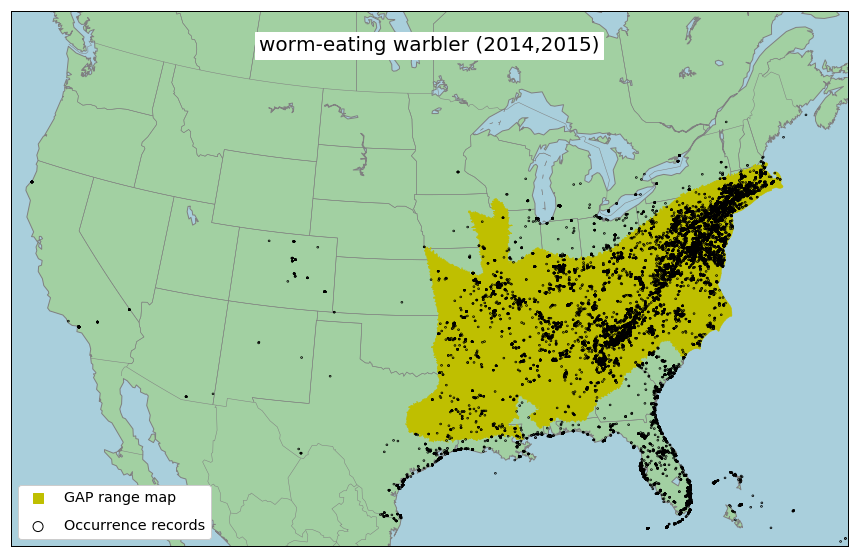

In [20]:
gap_range2 = "{0}{1}_range_4326".format(inDir, gap_id)

shp1 = {'file': gap_range2, 'column': None, 'alias': 'GAP range map',
        'drawbounds': False, 'linewidth': .5, 'linecolor': 'y',
        'fillcolor': 'y', 'marker':'s'}

shp2 = {'file': '{0}{1}_circles'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'k',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
if os.path.isfile(gap_range2 + ".shp"):
    map_these=[shp1, shp2]
else:
    map_these=[shp2]
    
title="{1} ({0})".format(years, common_name)
functions.MapShapefilePolygons(map_these=map_these, title=title)

### Years represented

Text(0.5, 1.0, 'Occurrences per Year')

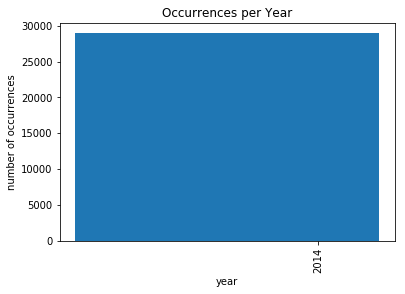

In [21]:
occ_years = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%Y', occurrenceDate) FROM occurrences").fetchall()]
years = connjup.execute("SELECT years_range FROM gbif_requests WHERE request_id = '{0}'".format(gbif_req_id)).fetchone()[0]
years = years.split(',')
yearsrng = list(range(int(years[0]), int(years[1]), 1))
binsnum = int(years[1]) - int(years[0])
plt.hist(occ_years, bins=binsnum)
plt.ylabel("number of occurrences")
plt.xlabel("year")
plt.xticks(yearsrng, rotation=90)
plt.title("Occurrences per Year")

### Months represented

Text(0.5, 1.0, 'Occurrences per Month')

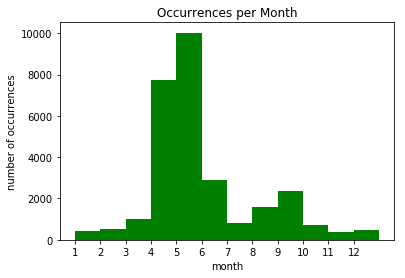

In [22]:
occ_months = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%m', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of occurrences")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

### Distribution of coordinate uncertainty values

Text(0.5, 1.0, 'Coordinate Uncertainty')

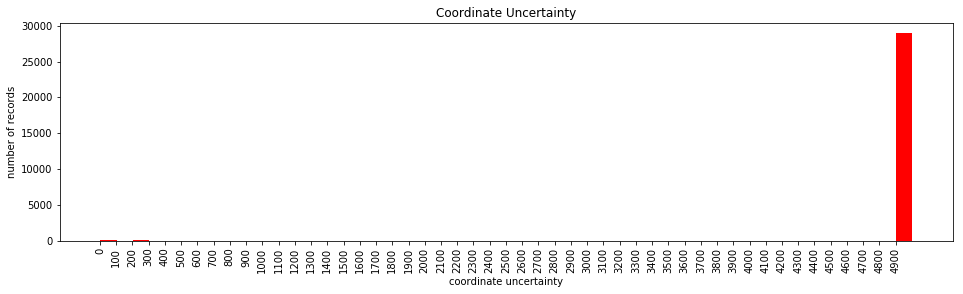

In [23]:
occ_cert = [int(x[0]) for x in curs_occ.execute("SELECT coordinateUncertaintyInMeters FROM occurrences").fetchall()]
maxi = np.max(occ_cert)
plt.figure(figsize=(16,4))
plt.hist(occ_cert, bins=50, color="r")
plt.xticks(range(0, maxi, int(maxi/50)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

Text(0.5, 1.0, 'Coordinate Uncertainty')

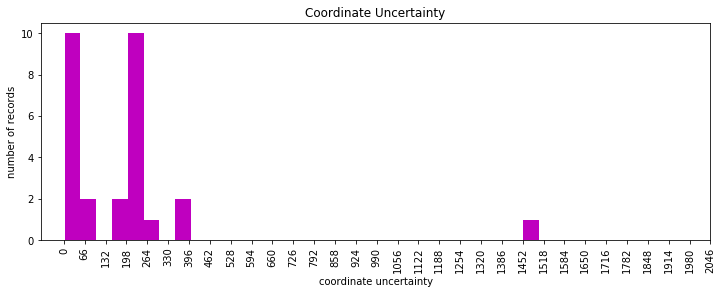

In [24]:
rng_max = 2000
occ_cert2 = [x for x in occ_cert if x <= rng_max]
plt.figure(figsize=(12,4))
plt.hist(occ_cert2, bins=30, color="m", align='mid')
plt.xticks(range(0, rng_max + 100, int(rng_max/30.)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

### Geodetic datums present

In [25]:
datums = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'datums' AND step = 'filter';").fetchone()[0]
datums = datums.replace('[', '').strip().replace(']', '').replace("'", "")
datums = datums.split()
for datum in datums:
    print(datum)

WGS84


### Establishment means reported

In [26]:
establishment = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'establishment' AND step = 'filter';").fetchall()[0]
for est in establishment:
    est = est.replace('[', '').strip().replace(']', '').replace("'", "")
    print(est)

### Identification qualifiers included

In [27]:
quali = curs_occ.execute("SELECT DISTINCT vals FROM record_attributes WHERE field = 'IDqualifier' AND step = 'filter';").fetchall()[0]
for q in quali:
    q = q.replace('[', '').strip().replace(']', '').replace("'", "")
    print(q)

### Remarks included

In [28]:
remarks = curs_occ.execute("SELECT DISTINCT remarks FROM occurrences;").fetchall()
#remarks = remarks.replace('[', '').strip().replace(']', '').replace("'", "")
#remarks = remarks.split(',')
if len(remarks) <= 20:
    for rem in remarks:
        if rem[0][0:1] == ';':
            print(rem[0][2:])
        else:
            print(rem[0])
else:
    print("More than 20 remarks, consult the occurrence database.")

More than 20 remarks, consult the occurrence database.


### Sources

In [29]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = [gbif_req_id, gbif_filter_id]

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

GBIF


### Attributes returned for the records in the request (pre-filters)

In [30]:
fields_summary = pd.read_sql("SELECT * FROM gbif_fields_returned", conn_occ, index_col='index')
fields_summary.index.name = 'field'
print(fields_summary)

                                      included(n)  populated(n)
field                                                          
acceptedScientificName                      28962         28962
acceptedTaxonKey                            28962         28962
accessRights                                    2             2
associatedTaxa                                  7             7
basisOfRecord                               28962         28962
behavior                                       19            19
bibliographicCitation                           1             1
catalogNumber                               28951         28951
class                                       28962         28962
classKey                                    28962         28962
collectionCode                              28951         28951
collectionID                                    1             1
continent                                       2             2
coordinateUncertaintyInMeters           

### Runtime

In [31]:
t2 = datetime.now()
print(t2 - t1)

0:45:39.836021
